# Linear Regression
The purpose of this notebook is to train, interpret and evaluate a linear regression predictive model for the Dublin Bikes app. To design the model, we used code learned from our Data Analytics module (COMP47350).

The model will predict the availability of bicycles at a station on a specified date, using the weather forecast.

There are three descriptive features: rainfall, temperature, and windspeed. 
We will use these three features to predict the target feature; the average daily availability of bikes at a station.


The model estimated is a linear model taking the form:

$target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $



## Reading data

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from flask import Flask, render_template, request
from sqlalchemy import create_engine
import pandas as pd
import traceback
import datetime
import dbinfo

# Allows plots to appear directly in the notebook.
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 


# dbinfo
user = dbinfo.USER
password = dbinfo.PASS
uri = dbinfo.DBURI
port = dbinfo.PORT
db = dbinfo.DBNAME

In [2]:
# Read the weather data into a dataframe.

def weather():
    engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{uri}:{port}/{db}", echo=True)
    query = "SELECT rainfall as 'rain', windspeed as 'wind', temp, DATE(time) as 'date' FROM weather;"
    df = pd.read_sql_query(query, engine)
    return df

# Read the dataframe.
wea_df = weather()

# The data is described by 4 features (4 descriptive features: rainfall, windspeed, and temperature).
wea_df.head(10)

2021-04-16 16:00:04,803 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-16 16:00:04,808 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:05,088 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-16 16:00:05,089 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:05,669 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-16 16:00:05,670 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:06,349 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-16 16:00:06,350 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:06,640 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-16 16:00:06,641 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:07,020 INFO sqlalchemy.engine.base.Engine SELECT rainfall as 'rain', windspeed as 'wind', temp, DATE(time) as 'date' FROM weather;
2021-04-16 16:00:07,022 INFO sqlalchemy

,rain,wind,temp,date
0,0.0,3.0,4,2021-03-02
1,6.5,9.0,12,2021-02-23
2,4.9,9.0,11,2021-02-23
3,1.8,8.0,11,2021-02-23
4,2.4,7.0,10,2021-02-23
5,2.4,7.0,10,2021-02-23
6,3.2,8.0,11,2021-02-24
7,0.4,10.0,11,2021-02-24
8,3.2,7.0,11,2021-02-24
9,0.0,7.0,11,2021-02-24


In [3]:
#As we want the daily average, I will group the data by the date and get the mean of the features
wea_df = wea_df.groupby(['date']).mean().reset_index()

#The average rainfall, windspeed, and temperature of the day is now shown on each date
wea_df.head(10)

,date,rain,wind,temp
0,2021-02-23,3.6000,8.000000,10.800000
1,2021-02-24,0.7375,5.791667,9.750000
2,2021-02-25,0.0000,4.416667,7.000000
3,2021-02-26,0.0000,3.416667,7.083333
4,2021-02-27,0.0000,2.083333,7.833333
5,2021-02-28,0.0000,2.416667,6.250000
6,2021-03-01,0.0000,3.083333,5.333333
7,2021-03-02,0.0000,2.500000,3.666667
8,2021-03-03,0.0000,3.291667,4.875000
9,2021-03-04,0.0000,4.375000,4.416667


In [4]:
# Print the feature types in our dataset.
wea_df.dtypes

date     object
rain    float64
wind    float64
temp    float64
dtype: object

### Addition of target feature (bike availability):

In [5]:
# We currently have 4 descriptive features, and need the target feature
# The target feature is the average daily availability of bikes at a station

def availability():
    engine2 = create_engine(f"mysql+mysqlconnector://{user}:{password}@{uri}:{port}/{db}", echo=True)
    query2 = "Select DATE(last_update) as 'date', number, avail_bikes from availability;"
    df2 = pd.read_sql_query(query2, engine2)
    # print(df2)
    return df2


# Read the dataframe.
av_df = availability()

av_df.head(10)

2021-04-16 16:00:11,069 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-16 16:00:11,071 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:11,346 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-16 16:00:11,347 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:11,889 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-16 16:00:11,890 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:12,434 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-16 16:00:12,436 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:12,709 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-16 16:00:12,710 INFO sqlalchemy.engine.base.Engine {}
2021-04-16 16:00:13,076 INFO sqlalchemy.engine.base.Engine Select DATE(last_update) as 'date', number, avail_bikes from availability;
2021-04-16 16:00:13,077 INFO sqlalchemy.engine.base.E

,date,number,avail_bikes
0,2021-02-23,42.0,18.0
1,2021-02-23,30.0,4.0
2,2021-02-23,54.0,5.0
3,2021-02-23,108.0,13.0
4,2021-02-23,56.0,12.0
5,2021-02-23,6.0,1.0
6,2021-02-23,18.0,14.0
7,2021-02-23,32.0,13.0
8,2021-02-23,52.0,4.0
9,2021-02-23,48.0,8.0


In [6]:
av_df.shape

(1609325, 3)

In [7]:
#As there are multiple inputs per day for each station
#We needs to get the average number of available bikes on each day

av_df = av_df.groupby(['date', 'number']).mean().reset_index()
av_df

,date,number,avail_bikes
0,2021-02-23,2.0,9.593220
1,2021-02-23,3.0,3.068966
2,2021-02-23,4.0,9.800000
3,2021-02-23,5.0,13.482759
4,2021-02-23,6.0,0.864407
...,...,...,...
5774,2021-04-16,113.0,10.793296
5775,2021-04-16,114.0,17.005587
5776,2021-04-16,115.0,19.167598
5777,2021-04-16,116.0,5.005587


In [8]:
# We will now merge both dataframes so all the information is in one dataframe

merged_df = pd.merge(av_df, wea_df, how='outer', on = 'date')
merged_df = merged_df.sort_values(by=['number', 'date'])
merged_df

,date,number,avail_bikes,rain,wind,temp
0,2021-02-23,2.0,9.593220,3.600000,8.000000,10.800000
109,2021-02-24,2.0,8.553191,0.737500,5.791667,9.750000
218,2021-02-25,2.0,9.349206,0.000000,4.416667,7.000000
327,2021-02-26,2.0,14.622378,0.000000,3.416667,7.083333
436,2021-02-27,2.0,15.559028,0.000000,2.083333,7.833333
...,...,...,...,...,...,...
5669,2021-04-15,117.0,1.725694,0.000000,3.541667,7.375000
5778,2021-04-16,117.0,0.966480,0.000000,2.800000,6.466667
3487,2021-03-26,507.0,0.801471,0.220833,7.000000,5.666667
3597,2021-03-27,507.0,0.884615,0.045833,6.791667,7.041667


### Cleaning the data

In [9]:
#There should only be stations between 2 and 117
#Numbers outside this range should be removed

test_df = merged_df[(merged_df['number'] > 117)]
test_df

#These three rows will need to be removed

,date,number,avail_bikes,rain,wind,temp
3487,2021-03-26,507.0,0.801471,0.220833,7.000000,5.666667
3597,2021-03-27,507.0,0.884615,0.045833,6.791667,7.041667
3707,2021-03-28,507.0,0.988827,0.079167,8.250000,12.708333


In [10]:
merged_df = merged_df[(merged_df['number'] <= 117)]
merged_df

,date,number,avail_bikes,rain,wind,temp
0,2021-02-23,2.0,9.593220,3.600000,8.000000,10.800000
109,2021-02-24,2.0,8.553191,0.737500,5.791667,9.750000
218,2021-02-25,2.0,9.349206,0.000000,4.416667,7.000000
327,2021-02-26,2.0,14.622378,0.000000,3.416667,7.083333
436,2021-02-27,2.0,15.559028,0.000000,2.083333,7.833333
...,...,...,...,...,...,...
5342,2021-04-12,117.0,1.616725,0.116667,3.291667,5.875000
5451,2021-04-13,117.0,0.695035,0.000000,2.625000,6.875000
5560,2021-04-14,117.0,1.637631,0.000000,2.750000,7.166667
5669,2021-04-15,117.0,1.725694,0.000000,3.541667,7.375000


### Testing on one specific station

In [11]:
#Sorting data and creating a model for each station number (using 9 as an example)
station_num = 9

In [12]:
#Below is an example of the average weather conditions and average available bikes at a given station on each date

merged_df = merged_df.loc[merged_df['number'] == station_num ]
merged_df = merged_df.sort_values(by=['date'])
merged_df.head(10)

,date,number,avail_bikes,rain,wind,temp
7,2021-02-23,9.0,14.706897,3.6000,8.000000,10.800000
116,2021-02-24,9.0,12.855319,0.7375,5.791667,9.750000
225,2021-02-25,9.0,8.243028,0.0000,4.416667,7.000000
334,2021-02-26,9.0,9.142361,0.0000,3.416667,7.083333
443,2021-02-27,9.0,7.742160,0.0000,2.083333,7.833333
552,2021-02-28,9.0,7.892361,0.0000,2.416667,6.250000
661,2021-03-01,9.0,7.584507,0.0000,3.083333,5.333333
770,2021-03-02,9.0,7.078853,0.0000,2.500000,3.666667
879,2021-03-03,9.0,8.073427,0.0000,3.291667,4.875000
988,2021-03-04,9.0,6.007435,0.0000,4.375000,4.416667


## Understanding data

In [13]:
# Looking at the correlations for all the features.
merged_df[['rain', 'wind', 'temp', 'avail_bikes']].corr()

,rain,wind,temp,avail_bikes
rain,1.000000,0.342535,0.215983,0.498545
wind,0.342535,1.000000,0.285368,0.065681
temp,0.215983,0.285368,1.000000,-0.156002
avail_bikes,0.498545,0.065681,-0.156002,1.000000


In [35]:
# Print the correlation for a given pair of features.
merged_df[['avail_bikes', 'rain']].corr().to_numpy()[0,1]

0.4985449754640059

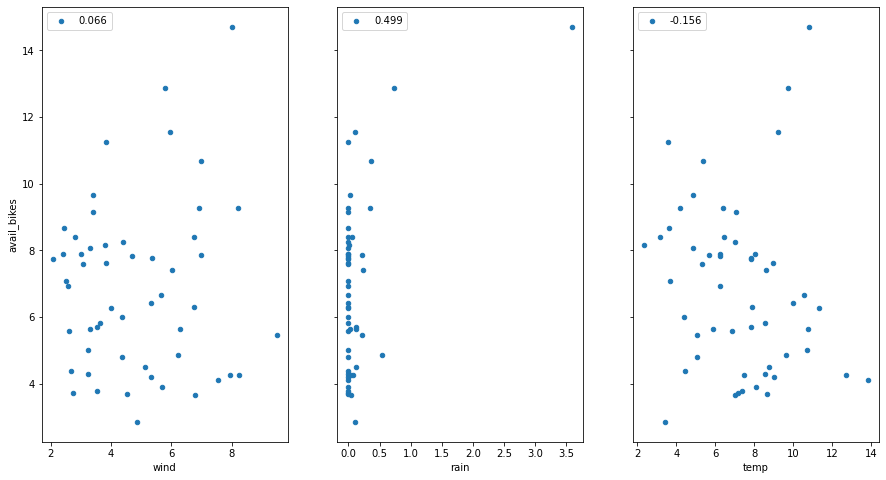

In [15]:
# Scatterplots for each descriptive feature and target feature. 
# Show the correlation value in the plot.
# This allows us to check strength of correlation with the target feature.
fig, axs = plt.subplots(1, 3, sharey=True)
merged_df.plot(kind='scatter', x='wind', y='avail_bikes', label="%.3f" % merged_df[['wind', 'avail_bikes']].corr().to_numpy()[0,1], ax=axs[0], figsize=(15, 8))
merged_df.plot(kind='scatter', x='rain', y='avail_bikes', label="%.3f" % merged_df[['rain', 'avail_bikes']].corr().to_numpy()[0,1], ax=axs[1])
merged_df.plot(kind='scatter', x='temp', y='avail_bikes', label="%.3f" % merged_df[['temp', 'avail_bikes']].corr().to_numpy()[0,1], ax=axs[2])

## Multiple linear regression

### Preparing the data

In [16]:
# Prepare the descriptive features

cont_features = ['rain', 'wind', 'temp']

X = merged_df[cont_features]
y = merged_df.avail_bikes

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
           rain      wind       temp
7     3.600000  8.000000  10.800000
116   0.737500  5.791667   9.750000
225   0.000000  4.416667   7.000000
334   0.000000  3.416667   7.083333
443   0.000000  2.083333   7.833333
552   0.000000  2.416667   6.250000
661   0.000000  3.083333   5.333333
770   0.000000  2.500000   3.666667
879   0.000000  3.291667   4.875000
988   0.000000  4.375000   4.416667
1097  0.000000  3.833333   3.583333
1206  0.000000  2.458333   3.625000
1315  0.000000  2.666667   4.458333
1423  0.129167  3.541667   7.833333
1532  0.241667  6.041667   8.625000
1641  0.537500  6.208333   9.625000
1750  0.341667  8.208333   6.375000
1859  0.362500  7.000000   5.375000
1968  0.212500  9.500000   5.041667
2077  0.033333  7.958333   7.458333
2186  0.000000  5.333333  10.000000
2295  0.020833  6.291667  10.791667
2404  0.000000  4.541667   8.666667
2513  0.000000  5.666667  10.583333
2622  0.000000  3.000000   8.041667
2731  0.000000  3.833333   8.958333

### Training the model

In [17]:
# Use more features for training
# Train aka fit, a model using all continuous features.

linreg = LinearRegression().fit(X[cont_features], y)

# Print the weights learned for each feature.
print("Features: \n", cont_features)
print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)

Features: 
 ['rain', 'wind', 'temp']
Coeficients: 
 [ 2.86267817 -0.07477321 -0.26160059]

Intercept: 
 8.741287592840676


### Testing the model
Using the trained model to predict the target feature avail_bikes, given the descriptive features rain, wind  temperature.

In [18]:
linreg_predictions = linreg.predict(X[cont_features])

print("\nPredictions with linear regression: \n")
actual_vs_predicted_linreg = pd.concat([y, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)
print(actual_vs_predicted_linreg)


Predictions with linear regression: 

      avail_bikes  Predicted
7       14.706897  15.623457
116     12.855319   7.868846
225      8.243028   6.579835
334      9.142361   6.632808
443      7.742160   6.536305
552      7.892361   6.925582
661      7.584507   7.115534
770      7.078853   7.595152
879      8.073427   7.219856
988      6.007435   7.258752
1097    11.250000   7.517255
1206     8.668990   7.609168
1315     4.390244   7.375590
1423     5.716263   6.797024
1532     7.410526   6.725042
1641     4.865517   7.297854
1750     9.263158   7.437902
1859    10.688581   7.849493
1968     5.477352   7.320358
2077     4.276224   6.290536
2186     6.415225   5.726491
2295     5.634146   5.507372
2404     3.700348   6.134488
2513     6.651568   5.548967
2622     7.905923   6.413263
2731     7.614583   6.111152
2840     5.811847   6.224830
2949     4.302083   6.263770
3058     4.220280   5.977192
3167     4.494810   6.403049
3276    11.538462   6.208910
3385     7.860627   7.367647
3495

In [34]:
#Pair the actual and the predicted values
prediction_errors = y - linreg_predictions
print("Actual - Predicted:\n", prediction_errors)
print("\n(Actual - Predicted) squared:\n", prediction_errors**2)
print("\n Sum of (Actual - Predicted) squared:\n", (prediction_errors**2).sum())

Actual - Predicted:
 7      -0.916560
116     4.986474
225     1.663193
334     2.509553
443     1.205855
552     0.966779
661     0.468973
770    -0.516299
879     0.853570
988    -1.251317
1097    3.732745
1206    1.059822
1315   -2.985346
1423   -1.080761
1532    0.685485
1641   -2.432337
1750    1.825256
1859    2.839088
1968   -1.843006
2077   -2.014312
2186    0.688734
2295    0.126774
2404   -2.434139
2513    1.102601
2622    1.492660
2731    1.503432
2840   -0.412983
2949   -1.961686
3058   -1.756912
3167   -1.908239
3276    5.329552
3385    0.492981
3495   -2.850081
3605   -0.765206
3715   -0.450551
3824    0.810806
3933   -0.686515
4042    0.116219
4151    1.078526
4260    0.027647
4369   -2.279714
4478    2.152058
4587    0.829133
4696   -2.272505
4805    1.486826
4914    2.358290
5023    0.285568
5132   -4.924019
5241   -1.637183
5350   -1.172036
5459   -2.932634
5568   -2.745078
5677    1.550823
Name: avail_bikes, dtype: float64

(Actual - Predicted) squared:
 7        0.8

In [20]:
# Print the Mean Squared Error of the model on the training set
mse = (prediction_errors** 2).mean()
rmse = ((prediction_errors** 2).mean())**0.5

print("\nMean Squared Error:\n", mse)
print("\nRoot Mean Squared Error:\n", rmse)


Mean Squared Error:
 4.215357072116136

Root Mean Squared Error:
 2.0531334764491413


In [21]:
print("|Actual - Predicted|:\n", abs(prediction_errors))

|Actual - Predicted|:
 7       0.916560
116     4.986474
225     1.663193
334     2.509553
443     1.205855
552     0.966779
661     0.468973
770     0.516299
879     0.853570
988     1.251317
1097    3.732745
1206    1.059822
1315    2.985346
1423    1.080761
1532    0.685485
1641    2.432337
1750    1.825256
1859    2.839088
1968    1.843006
2077    2.014312
2186    0.688734
2295    0.126774
2404    2.434139
2513    1.102601
2622    1.492660
2731    1.503432
2840    0.412983
2949    1.961686
3058    1.756912
3167    1.908239
3276    5.329552
3385    0.492981
3495    2.850081
3605    0.765206
3715    0.450551
3824    0.810806
3933    0.686515
4042    0.116219
4151    1.078526
4260    0.027647
4369    2.279714
4478    2.152058
4587    0.829133
4696    2.272505
4805    1.486826
4914    2.358290
5023    0.285568
5132    4.924019
5241    1.637183
5350    1.172036
5459    2.932634
5568    2.745078
5677    1.550823
Name: avail_bikes, dtype: float64


In [22]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(prediction_errors).mean()
print("\nMean Absolute Error:\n", mae)


Mean Absolute Error:
 1.6690347374008947


In [23]:
# Print the R2 of the model on the training set
#Pair the actual and the predicted values
#This can be done directly with sklearn functions, 
#but below is a manual example to understand how it works

prediction_errors = y - linreg_predictions
print("Actual - Predicted:\n", prediction_errors)
print("\n(Actual - Predicted) squared:\n", prediction_errors**2)
print("\n Sum of squared errors:\n", sum(prediction_errors**2))

avg_predictions =np.ones(y.shape[0])* merged_df.avail_bikes.mean()

print("\nAverageModelPredictions:\n", avg_predictions)
avgpredictions_errors = y - avg_predictions
print("Actual - AvgPredictions:\n", avgpredictions_errors)
print("\n(Actual - AvgPredictions) squared:\n", avgpredictions_errors**2)
print("\n Total sum of squared errors:\n", sum(avgpredictions_errors**2))

r2 = 1 - sum(prediction_errors**2)/sum(avgpredictions_errors**2)
print("\n R2:\n", r2)


Actual - Predicted:
 7      -0.916560
116     4.986474
225     1.663193
334     2.509553
443     1.205855
552     0.966779
661     0.468973
770    -0.516299
879     0.853570
988    -1.251317
1097    3.732745
1206    1.059822
1315   -2.985346
1423   -1.080761
1532    0.685485
1641   -2.432337
1750    1.825256
1859    2.839088
1968   -1.843006
2077   -2.014312
2186    0.688734
2295    0.126774
2404   -2.434139
2513    1.102601
2622    1.492660
2731    1.503432
2840   -0.412983
2949   -1.961686
3058   -1.756912
3167   -1.908239
3276    5.329552
3385    0.492981
3495   -2.850081
3605   -0.765206
3715   -0.450551
3824    0.810806
3933   -0.686515
4042    0.116219
4151    1.078526
4260    0.027647
4369   -2.279714
4478    2.152058
4587    0.829133
4696   -2.272505
4805    1.486826
4914    2.358290
5023    0.285568
5132   -4.924019
5241   -1.637183
5350   -1.172036
5459   -2.932634
5568   -2.745078
5677    1.550823
Name: avail_bikes, dtype: float64

(Actual - Predicted) squared:
 7        0.8

In [24]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
        

In [25]:
printMetrics(y, linreg_predictions)


MAE:  1.6690347374008951
RMSE:  2.053133476449141
R2:  0.3240762697536631


# Evaluation with train/test split

In [26]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
# Note that this training set if very small and the model will not be very reliable due to this sample size problem.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# If we want to get the same train/test split every time we run, we can set the random_state variable to a fixed value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
           rain      wind       temp  avail_bikes
2404  0.000000  4.541667   8.666667     3.700348
770   0.000000  2.500000   3.666667     7.078853
1532  0.241667  6.041667   8.625000     7.410526
3715  0.000000  7.541667  13.833333     4.108014
5241  0.116667  3.291667   5.875000     5.655052
1968  0.212500  9.500000   5.041667     5.477352
5459  0.000000  2.750000   7.166667     3.728223
3824  0.000000  4.000000  11.333333     6.288194
1641  0.537500  6.208333   9.625000     4.865517
552   0.000000  2.416667   6.250000     7.892361
3058  0.000000  5.333333   9.041667     4.220280
1750  0.341667  8.208333   6.375000     9.263158
4914  0.029167  3.416667   4.833333     9.663194
2186  0.000000  5.333333  10.000000     6.415225
5023  0.008333  3.791667   2.333333     8.156794
879   0.000000  3.291667   4.875000     8.073427
1423  0.129167  3.541667   7.833333     5.716263
2731  0.000000  3.833333   8.958333     7.614583
1859  0.362500  7.000000   5.375000    10.688581
5568

In [27]:
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)
# Print the weights learned for each feature.
#print(linreg_train.coef_)
print("Features and coeficients:", list(zip(cont_features, linreg.coef_)))

Features and coeficients: [('rain', 2.8486958475627833), ('wind', -0.06226234707864556), ('temp', -0.1766935350522985)]


In [28]:
X_train.head(10)

,rain,wind,temp
2404,0.000000,4.541667,8.666667
770,0.000000,2.500000,3.666667
1532,0.241667,6.041667,8.625000
3715,0.000000,7.541667,13.833333
5241,0.116667,3.291667,5.875000
1968,0.212500,9.500000,5.041667
5459,0.000000,2.750000,7.166667
3824,0.000000,4.000000,11.333333
1641,0.537500,6.208333,9.625000
552,0.000000,2.416667,6.250000


In [29]:
y_train.head(10)

2404    3.700348
770     7.078853
1532    7.410526
3715    4.108014
5241    5.655052
1968    5.477352
5459    3.728223
3824    6.288194
1641    4.865517
552     7.892361
Name: avail_bikes, dtype: float64

In [30]:
train_predictions = linreg.predict(X_train)
train_predictions

array([ 6.02320947,  7.03379611,  6.62561301,  4.92350583,  6.92665471,
        6.96035393,  6.39980315,  5.58575215,  7.28128161,  6.58252634,
        5.90765837,  7.1731413 ,  6.85366679,  5.73832707,  7.21270442,
        6.77100039,  6.60067298,  6.01577635,  7.48441633,  6.31370097,
        7.01183226,  7.85487673,  6.88353667,  6.0536413 ,  6.22963072,
        6.70298718,  5.61450172,  5.74288237,  5.59812443,  6.118941  ,
        6.78453406,  6.57214928,  6.45912156,  6.37301938, 15.68624437,
        7.22683557,  6.1185688 ])

In [31]:
train_pred = pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)
train_pred.head(10)

,Predicted
2404,6.023209
770,7.033796
1532,6.625613
3715,4.923506
5241,6.926655
1968,6.960354
5459,6.399803
3824,5.585752
1641,7.281282
552,6.582526


In [32]:
# Predicted avail_bikes on training set
train_predictions = linreg.predict(X_train)
print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, train_predictions)

Actual vs predicted on training:
       avail_bikes  Predicted
2404     3.700348   6.023209
770      7.078853   7.033796
1532     7.410526   6.625613
3715     4.108014   4.923506
5241     5.655052   6.926655
1968     5.477352   6.960354
5459     3.728223   6.399803
3824     6.288194   5.585752
1641     4.865517   7.281282
552      7.892361   6.582526
3058     4.220280   5.907658
1750     9.263158   7.173141
4914     9.663194   6.853667
2186     6.415225   5.738327
5023     8.156794   7.212704
879      8.073427   6.771000
1423     5.716263   6.600673
2731     7.614583   6.015776
1859    10.688581   7.484416
5568     3.802083   6.313701
4587     8.392361   7.011832
116     12.855319   7.854877
1315     4.390244   6.883537
4369     3.920139   6.053641
2622     7.905923   6.229631
661      7.584507   6.702987
2513     6.651568   5.614502
3933     5.010453   5.742882
2295     5.634146   5.598124
2077     4.276224   6.118941
988      6.007435   6.784534
4260     6.940767   6.572149
5350     

## Adding each model to a pickle file

Following training and evaluation, we added each model to a dictionary and subsequently added it to a pickle file.

In [ ]:
import pickle

dictionary[station_id] = LinearRegression().fit(X[cont_features], y)

with open('model.pkl', 'wb') as handle:
    pickle.dump(dictionary, handle, protocol=HIGHEST_protocol)